In [ ]:
!pip install numpy pandas matplotlib tensorflow pillow scikit-learn requests
!pip install idx2numpy

In [22]:
# Required imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input
import tkinter as tk
from PIL import Image, ImageDraw, ImageOps, ImageEnhance
import pickle
import os
from sklearn.model_selection import train_test_split
import requests
import gzip
import idx2numpy
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [23]:
class HandwritingRecognitionSystem:
    def __init__(self):
        self.model = None
        self.history = None
        self.num_classes = None
        
    def load_data(self):
        """Load MNIST dataset"""
        print("Loading MNIST dataset...")
        (self.x_train, self.y_train), (self.x_test, self.y_test) = tf.keras.datasets.mnist.load_data()
        
        # Normalize and reshape the data
        self.x_train = self.x_train.astype('float32') / 255.0
        self.x_test = self.x_test.astype('float32') / 255.0
        
        # Reshape data for CNN
        self.x_train = self.x_train.reshape((-1, 28, 28, 1))
        self.x_test = self.x_test.reshape((-1, 28, 28, 1))
        
        # One-hot encode the labels
        self.y_train = tf.keras.utils.to_categorical(self.y_train)
        self.y_test = tf.keras.utils.to_categorical(self.y_test)
        
        self.num_classes = self.y_train.shape[1]
        print(f"Data loaded successfully. Number of classes: {self.num_classes}")
        
    def build_model(self):
        """Build an improved CNN model"""
        self.model = models.Sequential([
            # Input layer
            layers.Input(shape=(28, 28, 1)),
            
            # First convolutional block
            layers.Conv2D(32, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Conv2D(32, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),
            
            # Second convolutional block
            layers.Conv2D(64, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Conv2D(64, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),
            
            # Dense layers
            layers.Flatten(),
            layers.Dense(512),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Dropout(0.5),
            layers.Dense(self.num_classes, activation='softmax')
        ])
        
        # Compile model with learning rate schedule
        initial_learning_rate = 0.001
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate, decay_steps=1000, decay_rate=0.9
        )
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        
        self.model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        print("Model built successfully")
        self.model.summary()
        
    def train_model(self, epochs=15, batch_size=64):
        # Create data augmentation generator
        datagen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            shear_range=0.1
        )
        
        # Train the model with data augmentation
        self.history = self.model.fit(
            datagen.flow(self.x_train, self.y_train, batch_size=batch_size),
            epochs=epochs,
            validation_data=(self.x_test, self.y_test),
            steps_per_epoch=len(self.x_train) // batch_size
        )
        
        self.model.save('handwriting_model.h5')
        print("Model trained and saved successfully")

    def evaluate_model(self):
        # Evaluate the model
        test_loss, test_acc = self.model.evaluate(self.x_test, self.y_test)
        print(f'\nTest accuracy: {test_acc:.3f}')
        
        # Plot training history
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

In [24]:
class DrawingApp:
    def __init__(self, model_path='handwriting_model.h5'):
        self.root = tk.Tk()
        self.root.title("Handwriting Recognition")
        
        self.model = tf.keras.models.load_model(model_path)
        
        # Increase canvas size for better drawing
        self.canvas = tk.Canvas(self.root, width=280, height=280, bg='white')
        self.canvas.pack(pady=20)
        
        self.clear_button = tk.Button(self.root, text="Clear", command=self.clear_canvas)
        self.clear_button.pack(pady=10)
        
        self.predict_button = tk.Button(self.root, text="Predict", command=self.predict)
        self.predict_button.pack(pady=10)
        
        self.result_label = tk.Label(self.root, text="Draw a digit (0-9) and click Predict")
        self.result_label.pack(pady=10)
        
        self.drawing = False
        self.last_x = None
        self.last_y = None
        
        self.canvas.bind('<Button-1>', self.start_drawing)
        self.canvas.bind('<B1-Motion>', self.draw)
        self.canvas.bind('<ButtonRelease-1>', self.stop_drawing)
        
        self.image = Image.new('L', (280, 280), 'white')
        self.draw = ImageDraw.Draw(self.image)
        
    def preprocess_image(self, img):
        """Enhanced image preprocessing"""
        # Convert to grayscale and enhance contrast
        img = ImageOps.invert(img)  # Invert colors to match MNIST
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(2.0)  # Increase contrast
        
        # Crop to content
        bbox = ImageOps.invert(img).getbbox()
        if bbox:
            img = img.crop(bbox)
        
        # Add padding
        pad_size = int(max(img.size) * 0.2)
        img = ImageOps.expand(img, border=pad_size, fill=0)
        
        # Resize maintaining aspect ratio
        target_size = 20  # Slightly smaller than 28x28 to add padding
        ratio = min(target_size / img.size[0], target_size / img.size[1])
        new_size = tuple(int(dim * ratio) for dim in img.size)
        img = img.resize(new_size, Image.LANCZOS)
        
        # Create 28x28 image with padding
        final_img = Image.new('L', (28, 28), 0)
        paste_pos = ((28 - img.size[0]) // 2, (28 - img.size[1]) // 2)
        final_img.paste(img, paste_pos)
        
        return final_img
    
    def predict(self):
        # Preprocess the drawn image
        img = self.preprocess_image(self.image)
        
        # Convert to numpy array and normalize
        img_array = np.array(img)
        img_array = img_array.astype('float32') / 255.0
        img_array = img_array.reshape(1, 28, 28, 1)
        
        # Make prediction with confidence threshold
        prediction = self.model.predict(img_array)
        predicted_class = np.argmax(prediction[0])
        confidence = prediction[0][predicted_class] * 100
        
        # Only show prediction if confidence is above threshold
        if confidence > 40:
            self.result_label.config(
                text=f'Predicted digit: {predicted_class} (Confidence: {confidence:.2f}%)')
        else:
            self.result_label.config(
                text='Unable to make confident prediction. Please try again.')
    
    def start_drawing(self, event):
        self.drawing = True
        self.last_x = event.x
        self.last_y = event.y
        
    def draw(self, event):
        if self.drawing:
            x, y = event.x, event.y
            if self.last_x and self.last_y:
                self.canvas.create_line(self.last_x, self.last_y, x, y, 
                                     width=20, fill='black', capstyle=tk.ROUND, 
                                     smooth=tk.TRUE)
                self.draw.line([self.last_x, self.last_y, x, y], 
                             fill='black', width=20)
            self.last_x = x
            self.last_y = y
            
    def stop_drawing(self, event):
        self.drawing = False
        self.last_x = None
        self.last_y = None
        
    def clear_canvas(self):
        self.canvas.delete('all')
        self.image = Image.new('L', (280, 280), 'white')
        self.draw = ImageDraw.Draw(self.image)
        self.result_label.config(text="Draw a digit (0-9) and click Predict")
        
    def run(self):
        self.root.mainloop()

Loading MNIST dataset...
Data loaded successfully. Number of classes: 10
Model built successfully


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,606,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,679,082 (6.41 MB)

 Trainable params: 1,677,674 (6.40 MB)

 Non-trainable params: 1,408 (5.50 KB)

C:\Users\KARTHIKEYA REDDY\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
937/937 ━━━━━━━━━━━━━━━━━━━━ 114s 112ms/step - accuracy: 0.8568 - loss: 0.4505 - val_accuracy: 0.9787 - val_loss: 0.0699
Epoch 2/15
  1/937 ━━━━━━━━━━━━━━━━━━━━ 1:41 108ms/step - accuracy: 0.9688 - loss: 0.0825

C:\Program Files\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


937/937 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9688 - loss: 0.0825 - val_accuracy: 0.9802 - val_loss: 0.0649
Epoch 3/15
937/937 ━━━━━━━━━━━━━━━━━━━━ 108s 115ms/step - accuracy: 0.9704 - loss: 0.0935 - val_accuracy: 0.9908 - val_loss: 0.0276
Epoch 4/15
937/937 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9844 - loss: 0.0579 - val_accuracy: 0.9903 - val_loss: 0.0289
Epoch 5/15
937/937 ━━━━━━━━━━━━━━━━━━━━ 108s 115ms/step - accuracy: 0.9776 - loss: 0.0707 - val_accuracy: 0.9872 - val_loss: 0.0405
Epoch 6/15
937/937 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9844 - loss: 0.0661 - val_accuracy: 0.9862 - val_loss: 0.0437
Epoch 7/15
937/937 ━━━━━━━━━━━━━━━━━━━━ 108s 115ms/step - accuracy: 0.9805 - loss: 0.0619 - val_accuracy: 0.9919 - val_loss: 0.0246
Epoch 8/15
937/937 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 1.0000 - loss: 0.0373 - val_accuracy: 0.9917 - val_loss: 0.0249
Epoch 9/15
937/937 ━━━━━━━━━━━━━━━━━━━━ 108s 115ms/step - accuracy: 0.9838 - loss: 0.0513 - val_accurac

Model trained and saved successfully
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9930 - loss: 0.0174

Test accuracy: 0.994


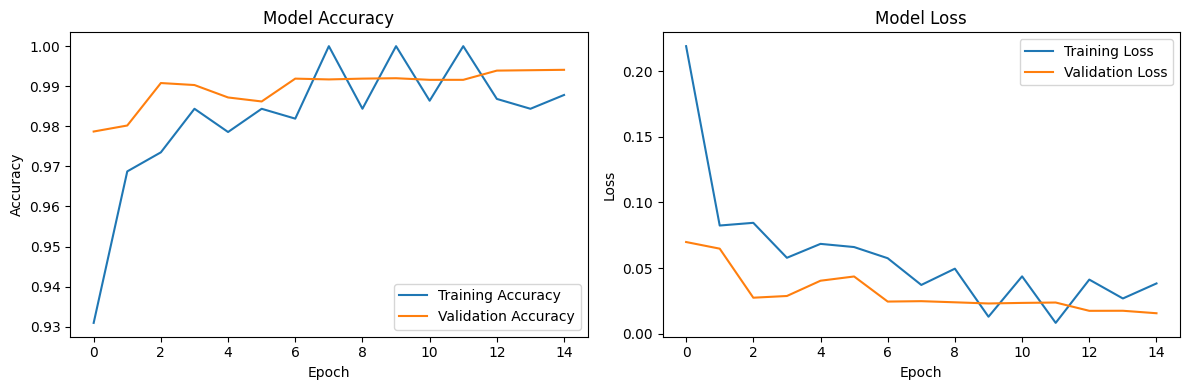

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [25]:

def main():
    # Train the model
    recognition_system = HandwritingRecognitionSystem()
    recognition_system.load_data()
    recognition_system.build_model()
    recognition_system.train_model(epochs=15)
    recognition_system.evaluate_model()
    
    # Launch the GUI application
    app = DrawingApp()
    app.run()

if __name__ == "__main__":
    main()

In [26]:
    # Launch the GUI application
    app = DrawingApp()
    app.run()